In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter7()
# This is needed to render the plots in this chapter
from plots.chapter7 import *

Finished!


In [2]:
from stepbystep.v3 import StepByStep

In [3]:
import random
import numpy as np
from copy import deepcopy
import shutil

from tqdm import tqdm
from PIL import Image
import pandas as pd

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms.v2 import Compose, ToImage, Normalize, ToPILImage, Resize, ToDtype
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

import matplotlib.pyplot as plt
import requests
import zipfile
import os
import errno

plt.style.use('fivethirtyeight')

In [4]:
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms.v2 import Compose, ToImage, Normalize,  \
Resize, ToPILImage, CenterCrop, RandomResizedCrop, ToDtype, ToTensor
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, resnet18, inception_v3

# Updated for Torchvision 0.15
from torchvision.models.alexnet import AlexNet_Weights
from torchvision.models.inception import Inception_V3_Weights
from torchvision.models.resnet import ResNet18_Weights
# from torchvision.models.alexnet import model_urls

import os
import shutil

In [5]:
def split_dataset(
    input_dir, output_dir, split_ratio=0.8, seed=42
):
    random.seed(seed)

    # Cria pastas de saída
    for split in ['train', 'val']:
        split_path = os.path.join(output_dir, split)
        os.makedirs(split_path, exist_ok=True)

    # Para cada classe
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        # Lista todos os arquivos de imagem
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        random.shuffle(files)

        # Divide conforme o split_ratio
        split_idx = int(len(files) * split_ratio)
        train_files = files[:split_idx]
        val_files = files[split_idx:]

        # Copia os arquivos para suas novas pastas
        for split, split_files in [('train', train_files), ('val', val_files)]:
            split_class_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for filename in tqdm(split_files, desc=f'{split}/{class_name}'):
                src_path = os.path.join(class_path, filename)
                dst_path = os.path.join(split_class_dir, filename)
                shutil.copy2(src_path, dst_path)

In [6]:
import kagglehub

path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Caminho para o dataset:", path)

split_dataset(input_dir=os.path.join(path, "raw-img"), output_dir="./animals_split", split_ratio=0.8)

Caminho para o dataset: /kaggle/input/animals10


val/farfalla: 100%|██████████| 423/423 [00:03<00:00, 126.86it/s]


In [7]:
# ImageNet statistics
normalizer = Normalize( mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])

composer = Compose([Resize(224),
                    CenterCrop(224),
                    ToImage(),
                    ToDtype(torch.float32, scale=True),
                    normalizer])

train_data = ImageFolder(root='/content/animals_split/train', transform=composer)
val_data = ImageFolder(root='/content/animals_split/val', transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

In [8]:
# repeating import from the top for reference
from torchvision.models.resnet import ResNet18_Weights

# UPDATED
###########################################################
# This is the recommended way of loading a pretrained
# model's weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)
# model = resnet18(pretrained=True)
###########################################################

torch.manual_seed(42)
model.fc = nn.Linear(512, 10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


In [9]:
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_model = optim.Adam(model.parameters(), lr=3e-4)
sbs_transfer = StepByStep(model, multi_loss_fn, optimizer_model)

In [10]:
sbs_transfer.set_loaders(train_loader, val_loader)
sbs_transfer.train(3)

In [11]:
StepByStep.loader_apply(val_loader, sbs_transfer.correct)

tensor([[874, 973],
        [432, 525],
        [276, 290],
        [404, 423],
        [595, 620],
        [305, 334],
        [307, 374],
        [296, 364],
        [935, 965],
        [317, 373]])

In [ ]:
classes = ('cavalo', 'gato', 'borboleta', 'esquilo',
           'aranha', 'elefante', 'cachorro', 'gado', 'galinha', 'ovelha')

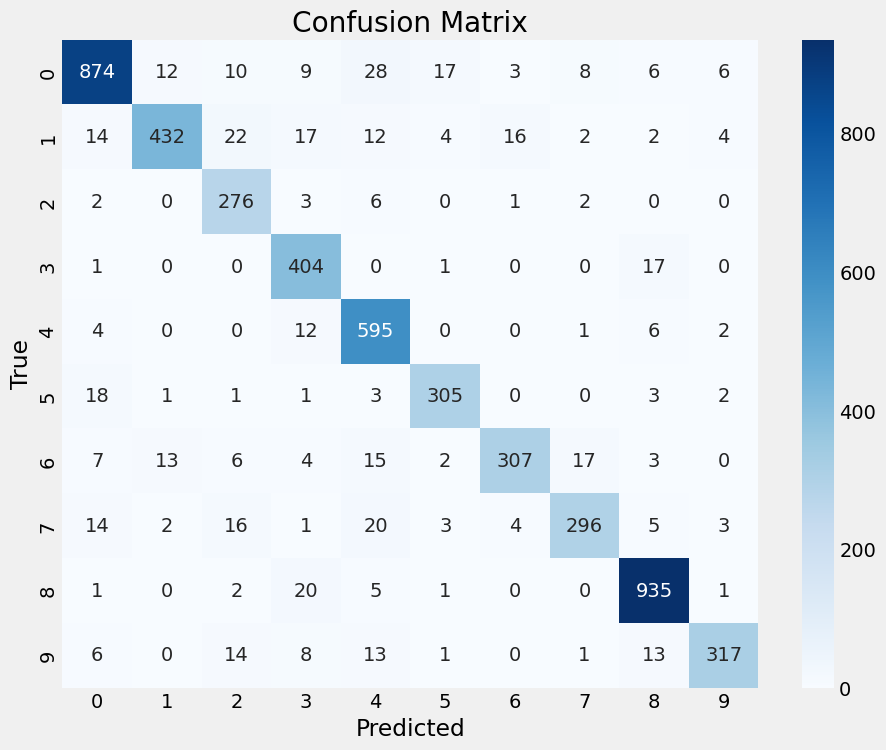

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(sbs_transfer.device)
        y_batch = y_batch.to(sbs_transfer.device)

        sbs_transfer.model.eval()
        yhat = sbs_transfer.model(x_batch)

        _, predicted = torch.max(yhat, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()